# Модель-пример

#### Импорт необходимых библиотек

In [3]:
import sys

import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import torchvision as tv
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from livelossplot import PlotLossesKeras

sys.path.append('../../')

from core.datasets import get_ds
from core.make_answer import make_ans_file

In [4]:
transformer = tv.transforms.Compose([
    tv.transforms.RandomAdjustSharpness(sharpness_factor=5, p=.4),
    tv.transforms.RandomHorizontalFlip(p=.5),
    tv.transforms.RandomPosterize(bits=3, p=.3),
    tv.transforms.RandomPerspective(distortion_scale=0.2, p=.5),
    tv.transforms.RandomRotation(degrees=(-10, 10)),
    tv.transforms.ColorJitter(brightness=.2, hue=0.2),
])

In [6]:
train_ds, val_ds, test_ds = get_ds('repaired_data_train', 'repaired_data_test', transform=transformer, one_hot=True, back=2)

In [7]:
val_ds_x = np.array([i[0] for i in val_ds.unbatch().as_numpy_iterator()])
val_ds_y = np.array([i[1] for i in val_ds.unbatch().as_numpy_iterator()])

In [13]:
C_EN_MODEL1 = tf.keras.Sequential([
    tf.keras.Input(shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.AveragePooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.AveragePooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0,2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0,2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10),
])
C_EN_MODEL1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 26, 26, 128)      512       
 hNormalization)                                                 
                                                                 
 average_pooling2d_2 (Averag  (None, 13, 13, 128)      0         
 ePooling2D)                                                     
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 128)      

#### Создаем чекпоинты (всем уже рассказал)
- Если лень, то просто копипаст того, что я написал ниже. НЕ ЗАБЫВАЕМ МЕНЯТЬ ПЕРЕМЕННУЮ `num_model`!!!

In [9]:
metrics = ['categorical_accuracy',
           tfa.metrics.F1Score(num_classes=10, average='macro', name='f1_score')]
num_model = "_C_EN_1"
callbacks = [
    PlotLossesKeras(),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_categorical_accuracy.h5',
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_loss.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_f1_score.h5',
        monitor='val_f1_score',
        mode='max',
        save_best_only=True,
    ),
]

#### Компиляция модели
- Если будете что то менять, то только оптимизатор. Про оптимизаторы написано у Лизы.

In [14]:
C_EN_MODEL1.compile(
    optimizer='adam', metrics=metrics,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
)

In [15]:
C_EN_MODEL1 = tf.keras.models.load_model(f'../../notebooks/Comissar/checkpoints/model{num_model}_categorical_accuracy.h5')

#### Обучаем модель

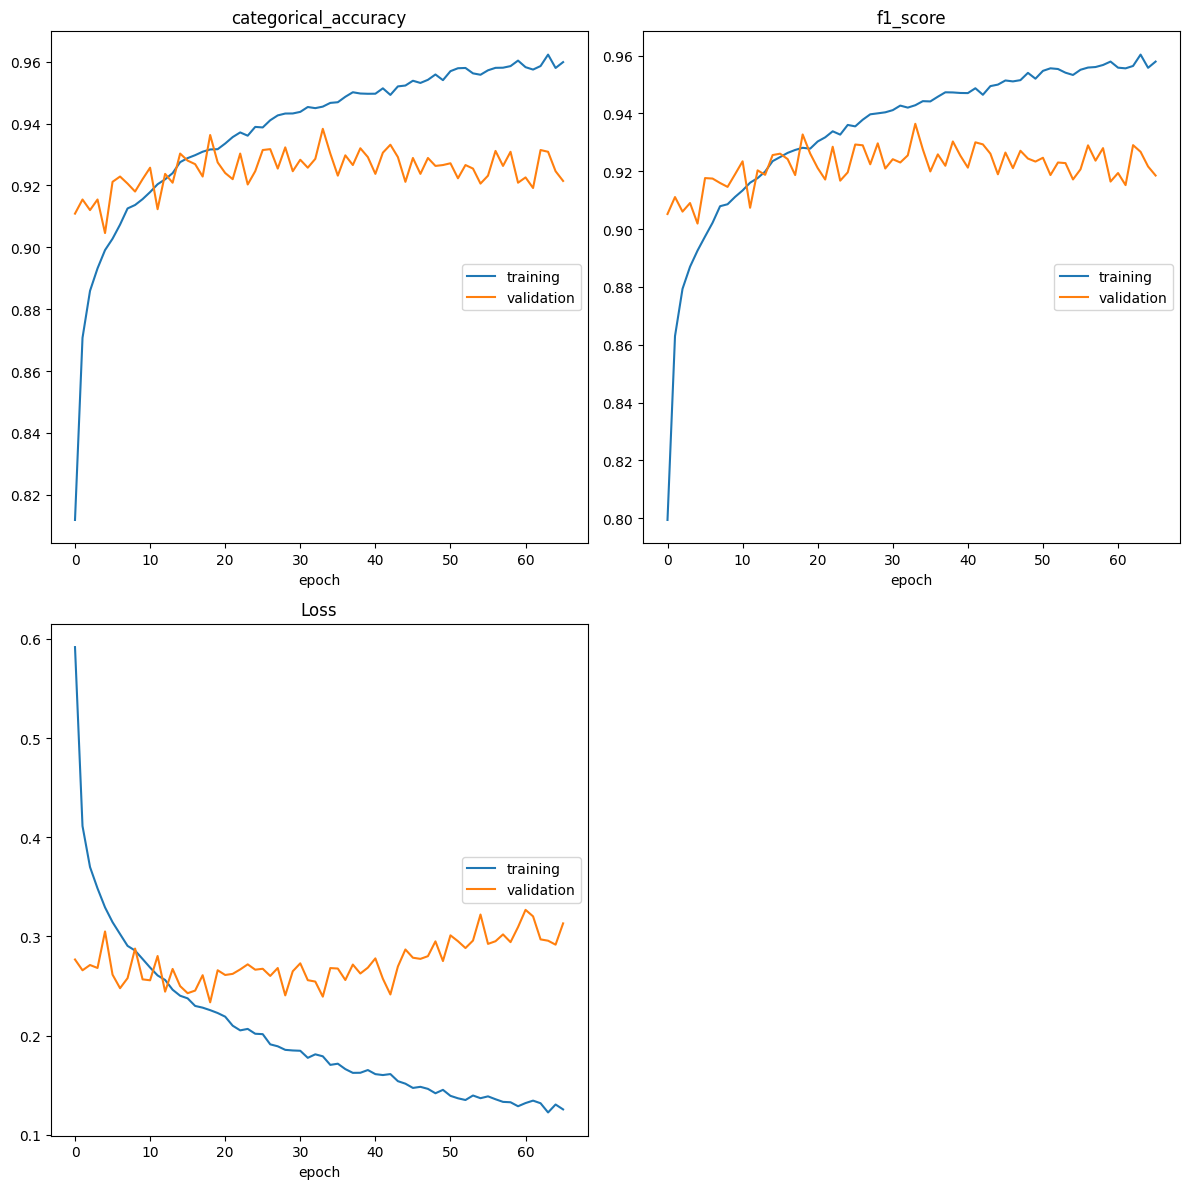

categorical_accuracy
	training         	 (min:    0.812, max:    0.962, cur:    0.960)
	validation       	 (min:    0.905, max:    0.938, cur:    0.921)
f1_score
	training         	 (min:    0.799, max:    0.960, cur:    0.958)
	validation       	 (min:    0.902, max:    0.936, cur:    0.919)
Loss
	training         	 (min:    0.123, max:    0.592, cur:    0.126)
	validation       	 (min:    0.234, max:    0.327, cur:    0.313)
91/91 [==============================] - 98s 1s/step - loss: 0.1257 - categorical_accuracy: 0.9599 - f1_score: 0.9579 - val_loss: 0.3132 - val_categorical_accuracy: 0.9215 - val_f1_score: 0.9185
Epoch 67/100
83/91 [==========================>...] - ETA: 8s - loss: 0.1219 - categorical_accuracy: 0.9613 - f1_score: 0.9593

KeyboardInterrupt: 

In [16]:
C_EN_MODEL1.fit(train_ds, validation_data=val_ds,
            epochs=100, callbacks=callbacks, verbose=1)

Подгружаем все чекпоинты

In [58]:
model_1 = tf.keras.models.load_model(f'../../../models/checkpoints/model1_categorical_accuracy.h5')
model_3 = tf.keras.models.load_model(f'../../../models/checkpoints/model3_categorical_accuracy.h5')



У нас поличилось три чекпоинта (три модели). Ниже указан код для получения ответов для всех чекпоинтов по валидационному датасету.

In [7]:
ans_val_categorical_accuracy = make_ans_file(model_categorical_acc, val_ds_x)
ans_val_f1_score = make_ans_file(model_f1_score, val_ds_x)
ans_val_loss = make_ans_file(model_loss, val_ds_x)

Формируем валидационные ответы.

In [8]:
val_ds_y = np.argmax(val_ds_y, axis=1)

Сравниваем валидационные предикты каждого чекпоинта

В конце смотрим на метрики и делаем выводы о том, чем хороша эта модель. Какие классы она угадывает лучше/худше всего. Дописываем какую метрику показал kaggle.

In [28]:
class MulticlassClassificationMetrics:
    def __init__(self, y_true, y_pred):
        self.y_true = np.array(y_true)
        self.y_pred = np.array(y_pred)
        self.matrix_error = self.get_matrix_error()

    def get_matrix_error(self):
        self.class_types = np.unique([self.y_true, self.y_pred])
        TP, FN, FP, TN = [], [], [], []
        for class_type in self.class_types:
            TP.append(np.sum(np.logical_and(self.y_true == self.y_pred, self.y_true == class_type)))
            FN.append(np.sum(np.logical_and(self.y_true == class_type, self.y_pred != class_type)))
            FP.append(np.sum(np.logical_and(self.y_pred == class_type, self.y_true != class_type)))
            TN.append(np.sum(np.logical_and(self.y_pred != class_type, self.y_true != class_type)))
        return pd.DataFrame({
            'class_type': self.class_types,
            'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
        }).set_index('class_type')

    def accuracy(self):
        return np.sum(self.y_true == self.y_pred) / self.y_true.shape[0]

    def precision(self, averaging='macro'):
        if averaging == 'macro':
            precisions = self.matrix_error['TP'] / (self.matrix_error['TP'] + self.matrix_error['FP'])
            return np.mean(precisions.replace(np.nan, 0))
        elif averaging == 'micro':
            mean_val = self.matrix_error.mean()
            return mean_val['TP'] / (mean_val['TP'] + mean_val['FP'])

    def recall(self, averaging='macro'):
        if averaging == 'macro':
            recalls = self.matrix_error['TP'] / (self.matrix_error['TP'] + self.matrix_error['FN'])
            return np.mean(recalls.replace(np.nan, 0))
        elif averaging == 'micro':
            mean_val = self.matrix_error.mean()
            return mean_val['TP'] / (mean_val['TP'] + mean_val['FN'])

    def f1_score(self, averaging='macro'):
        if averaging == 'macro':
            reverse_r = (self.matrix_error['TP'] + self.matrix_error['FN']) / self.matrix_error['TP']
            reverse_p = (self.matrix_error['TP'] + self.matrix_error['FP']) / self.matrix_error['TP']
            f1_scores = 2 / (reverse_r + reverse_p)
            return np.mean(f1_scores.replace(np.nan, 0))
        elif averaging == 'micro':
            p = self.precision(averaging)
            r = self.recall(averaging)
            return 2 * p * r / (p + r)

    def metrics(self, averaging='macro'):
        return {
            'accuracy': self.accuracy(),
            'precision': self.precision(averaging),
            'recall': self.recall(averaging),
            'f1_score': self.f1_score(averaging),
        }

    def __str__(self):
        headers = {
            'selector': '*',
            'props': 'background-color: darkgreen; color: white; font-size: 12pt;',
        }
        che_super_mega_puper_visualization_of_cell = { 
            'selector': 'td:hover',
            'props': 'background-color: green; color: white;',
        }
        display(
            self.matrix_error
            .style
            .set_table_styles([
                headers,
                che_super_mega_puper_visualization_of_cell,
            ])
            .set_properties(**{'background-color': 'lightgreen',
                           'color': 'black', 'font-size': '12pt'})
        )
        return ''

    def __repr__(self):
        return (
            f'MulticlassClassificationMetrics(class_types={self.class_types})'
            .replace("'", '').replace(',', ';'))